# Nonlinear (quasilinear) Poisson equation

Next, we consider a nonlinear version of the Poisson equation to see how nonlinear problems can be handled in Fenics. The domain is a two-dimensional square with two circular holes as shown below:

<img src="results/nonlinear_poisson_setup.png" style="width:300px;">

## Domain

Consider a two-dimension domain $\Omega = (0,1)^2 - B(\boldsymbol{x}_1, r_1) - B(\boldsymbol{x}_2, r_2)$ shown in the figure above, where $B(\boldsymbol{x}, r)$ is the 2-d ball of radius $r$ centered $\boldsymbol{x}$. Here, $\boldsymbol{x}_1 = (0.2L, 0.8W), \boldsymbol{x}_2 = (0.7L, 0.3W), r_1 = 0.1L, r_2 = 0.2L$. 

For the rest of the tutorial, we fix $L = 0.8$ and $W = 1.2$.

Let 
\begin{equation}
\Gamma_{in} := \partial B(\boldsymbol{x}_1, r_1) \cup \partial B(\boldsymbol{x}_2, r_2), 
\end{equation}
where $\partial B(\boldsymbol{x}, r)$ denotes the boundary of ball $B(\boldsymbol{x}, r)$. Further let 
\begin{equation}
\Gamma_{out} = \partial \Omega - \Gamma_{in} = \{(x, y): x \in \{0, L\}, y \in [0, W]\} \cup \{(x, y): y \in \{0, W\}, x \in [0, L]\}. 
\end{equation}. 

## Strong form of the problem

We consider the following nonlinear (quasilinear) Poisson equation:
\begin{equation}
-div (\kappa (1+u^2) grad (u(x, y))) = f(x, y) \qquad \text{for } \qquad (x,y) \in \Omega,
\end{equation}
with the source $f$ given by
\begin{equation}
f(x, y) = x \sin(4y)
\end{equation}
and boundary conditions given by
\begin{align}
u &= 0 \qquad \text{ on } \qquad \Gamma_{in} \\
\kappa (1+ u^2) \nabla u \cdot n &= g \qquad \text{ on } \qquad \Gamma_{out} .
\end{align}
Here, $g(x,y) = (1 - x/L)^2 + (y/W)^2 - (1 - x/L)^2 (y/W)^2$. Further, we fix diffusivity constant to $\kappa = 0.75$. 

## Variational formulation

Let $V$ be the suitable function space then the variational problem associated to the above PDE reads: 
\begin{equation}
\text{find }\; u\in V \;\text{ such that }\quad \underbrace{\int_{\Omega} \kappa (1 + u^2) \nabla u \cdot \nabla v dx}_{=: a(u;v)} = \underbrace{\int_{\Omega} f v dx + \int_{\Gamma_{out}} g v ds}_{=:l(v)} \qquad \text{for all } \; v \in V.
\end{equation}
In the above, $a(u;v)$ is the semilinear form (nonlinear in $u$ and linear in $v$) and $l(v)$ is the linear form. Residual of the problem $R(u;v)$ is given by
\begin{equation}
R(u; v) := a(u; v) - l(v).
\end{equation}
Thus, the problem can be written as
\begin{equation}
\text{find }\; u\in V \;\text{ such that }\quad R(u; v) = 0 \qquad \text{for all } \; v \in V.
\end{equation}


## Finite element approximation
Let $V_h$ be the finite element function space. Then the finite element approximation reads: 
\begin{equation}
\text{find }\; u_h\in V_h \;\text{ such that }\quad R(u_h; v_h) = 0 \qquad \text{for all } \; v_h \in V_h.
\end{equation}

## Newton's iteration to solve the nonlinear problem
Let $u_k$ is the solution at the $k$th iteration step and we are interested in $\delta u$ such that $u_k + \delta u \approx u$, $u$ being the exact solution that satisfies $R(u; v) = 0$ for all $v$. Suppose $u = u_k + \delta u$. Then Taylor series expansion of $R(u; v)$ around $u_k$ is given by
\begin{equation}
R(u_k + \delta u; v) = R(u_k; v) + \delta_u R(u_k; \delta u, v) + O(||\delta u||^2),
\end{equation}
where $\delta_u R(u; q, v)$ is the variational (G\:ateaux) derivative of $R$ with respect to the first argument and is defined as
\begin{equation}
\delta_u R(u; q, v) = \lim_{\eta \to 0} \frac{R(u + \eta q; v) - R(u; v)}{\eta} = \int_{\Omega} \kappa \left[ 2 u q \nabla u \cdot \nabla v + (1+u^2) \nabla q \cdot \nabla v \right] dx.
\end{equation}

Now, setting $R(u_k + \delta u; v) \approx R(u_k; v) + \delta_u R(u_k; \delta u, v) = 0$ gives the equation for the increment $\delta u$ as follows: Given $u_k$, find $\delta u$ such that

\begin{equation}
\text{Given } u_k, \text{ find }\; u_h\in V_h \;\text{ such that }\quad \delta_u R(u_k; \delta u, v) = - R(u_k; v)  \qquad \text{for all }\quad v\in V.  
\end{equation}

> Because of homogeneous Dirichlet boundary condition on $\Gamma_{in}$, trial function $u$, increment/variation function $\delta u$, and test function $v$ all belong to the same function space $V$. If a nonzero Dirichlet boundary condition was specified then trial function will satisfy the nonzero Dirichlet boundary condition while the variation and test fucntion will satisfy homogeneous Dirichlet boundary condition. 

## Fenics implementation
We first import the dolfin package.

In [1]:
# dolfin includes fenics
import dolfin as dl

# for plotting
import matplotlib.pyplot as plt 

# for numpy and math
import numpy as np

### Load mesh
In this case, we create the mesh using `gmsh`, convert `.msh` file into `.xdmf`, and load it in Fenics. Mesh files are in folder [../meshing/rectangle_with_two_holes/](../meshing/rectangle_with_two_holes/) (See file [../meshing/create_mesh.ipynb](../meshing/create_mesh.ipynb) for details about creating this mesh). 

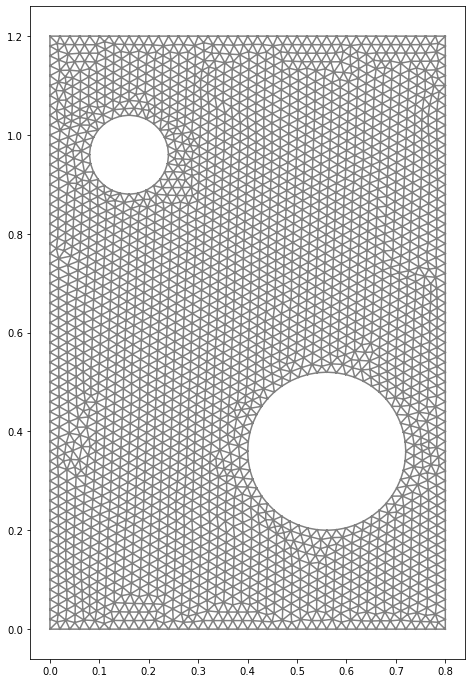

In [2]:
# geometry details that are used later also
omega_L = 0.8
omega_W = 1.2
hole_x1 = [0.2*omega_L, 0.8*omega_W]
hole_x2 = [0.7*omega_L, 0.3*omega_W]
hole_r1, hole_r2 = 0.1*omega_L, 0.2*omega_L

mesh = dl.Mesh()
mesh_fname = '../meshing/rectangle_with_two_holes/mesh_h_0.020'
# read xdmf file in fenics
with dl.XDMFFile(mesh_fname + '.xdmf') as infile:
    infile.read(mesh)

mvc = dl.MeshValueCollection("size_t", mesh, 2)
with dl.XDMFFile(mesh_fname + '_facet.xdmf') as infile:
    infile.read(mvc, "name_to_read")
    
sub = dl.cpp.mesh.MeshFunctionSizet(mesh, mvc)

# plot
plt.figure(figsize=(8,12))
dl.plot(mesh)

plt.show()

Create function space:

In [3]:
# specify order of interpolation
p_order = 2

# create FE function space
V = dl.FunctionSpace(mesh, "Lagrange", p_order) # or dl.FunctionSpace(mesh, "P", p_order)

### Define boundaries of the domain for boundary conditions

In [4]:
# Define inner and outer boundaries
def outer_bdry(x, on_boundary):
    return (   x[0] < dl.DOLFIN_EPS or x[0] > 1.0 - dl.DOLFIN_EPS or 
               x[1] < dl.DOLFIN_EPS or x[1] > 1.0 - dl.DOLFIN_EPS
           ) and on_boundary
    
def hole1(x, on_boundary): 
    return (    dl.near(x[0], hole_x1[0], hole_r1 + 0.01) and 
                dl.near(x[1], hole_x1[1], hole_r1 + 0.01) \
           ) and on_boundary

def hole2(x, on_boundary):
    return (    dl.near(x[0], hole_x2[0], hole_r2 + 0.01) and 
                dl.near(x[1], hole_x2[1], hole_r2 + 0.01) \
           ) and on_boundary

def inner_bdry(x, on_boundary):
    # identiy points close to the boundaries of two holes
    return hole1(x, on_boundary) or hole2(x, on_boundary)

Next, define surface measure for integration of neumann boundary condition over $\Gamma_{out}$

In [5]:
# create one dimension lower mesh, i.e., mesh consisting of edges (in 2-d domain) 
# (for 3-d, it will be mesh consisting of faces of elements)
# arg1: type of value of mesh function (integer, double, bool, etc.)
# arg2: mesh
# arg3: dimension of the output mesh (here it is 1 as we want list of edges)
facets = dl.MeshFunction("size_t", mesh, 1)

# now mark the edges that coincide with the horizontal edges of the domain
# note we use `outer_bdry` in below
dl.AutoSubDomain(outer_bdry).mark(facets, 1)

# create surface measure associated with the horizontal edges
ds = dl.Measure("ds", subdomain_data=facets)

Now, create function $g(x,y) = \sin(5x)$ for Neumann boundary condition

In [6]:
# degree specifies interpolation order when interpolating this function on to the mesh
g = dl.Expression("pow(1 - x[0]/omega_L, 2) + pow(x[1]/omega_W, 2) \
                    - pow(1 - x[0]/omega_L, 2)*pow(x[1]/omega_W, 2)", \
                  degree=2, \
                  omega_L = omega_L, \
                  omega_W = omega_W)

Now, create Dirichlet boundary condition object

In [7]:
u_bdr = dl.Constant(0.0) # use dolfin in-built Constant function

# now actually create boundary condition 
# arg1: function space, arg2: value of boundary condition, arg3: boundary domain
u_bc = dl.DirichletBC(V, u_bdr, inner_bdry)

## Method 1: Use Fenics in-built Newton solver for nonlinear variational equations
Once the residual $R(u;v)$ is defined, we can directly solve $R(u;v) = 0$ in Fenics. Fenics will internally take care of computing variational derivative of $R$ and use Newton step. 

### Define residual

In [8]:
# trial and test function (Here we use dl.Function)
u = dl.Function(V, name = 'u')
v = dl.TestFunction(V)

# forcing term
f = dl.Expression("x[0]*sin(x[1])", degree=2)

# diffusivity coefficient
kappa = dl.Constant(0.75)

# semilinear form
a = kappa * dl.inner((1 + u**2)*dl.grad(u), dl.grad(v))*dl.dx

# linear form
l = f*v*dl.dx + g*v*ds

# residual
R = a - l

### Solve the problem R = 0

In [9]:
# Compute solution 
# arg1: nonlinear variational equation
# arg2: solution u
# arg3: Dirichlet boundary condition
# arg4: Solver parameters
dl.solve(R == 0, u, u_bc, solver_parameters={"newton_solver":{"relative_tolerance":1e-6}})

No Jacobian form specified for nonlinear variational problem.
Differentiating residual form F to obtain Jacobian J = F'.
Solving nonlinear variational problem.
  Newton iteration 0: r (abs) = 1.634e-01 (tol = 1.000e-10) r (rel) = 1.000e+00 (tol = 1.000e-06)
  Newton iteration 1: r (abs) = 9.816e-02 (tol = 1.000e-10) r (rel) = 6.006e-01 (tol = 1.000e-06)
  Newton iteration 2: r (abs) = 1.194e-02 (tol = 1.000e-10) r (rel) = 7.302e-02 (tol = 1.000e-06)
  Newton iteration 3: r (abs) = 2.275e-04 (tol = 1.000e-10) r (rel) = 1.392e-03 (tol = 1.000e-06)
  Newton iteration 4: r (abs) = 7.488e-08 (tol = 1.000e-10) r (rel) = 4.582e-07 (tol = 1.000e-06)
  Newton solver finished in 4 iterations and 4 linear solver iterations.


Save solution and plot result

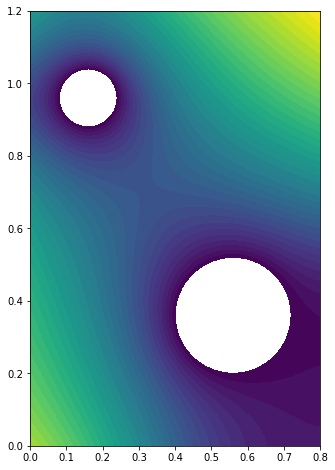

In [10]:
# Save solution in VTK format
file = dl.File("fwd_result/nonlinear_poisson_equation.pvd")
file << u

# Plot solution
plt.figure(figsize=(8,8))
dl.plot(u)
plt.show()

To compare with other methods, we save this solution as $u_{direct}$

In [11]:
u_direct = dl.Function(V, name = 'u_direct')
u_direct.vector().zero()
u_direct.vector().axpy(1., u.vector())

### Plotting in paraview
- load file `poisson_equation.pvd` in paraview
- apply `warp by scalar` filter
- click on `2D` in view panel to change view to `3D`

The result looks as follows

<img src="results/fenics_solve_result/nonlinear_poisson_equation_result.png" style="width:600px;">

## Method 2: Implement Newton solver

### Newton's method

Let $u_k$ is the solution at the $k$th step and we are interested in $\delta u$ such that $u_k + \delta u \approx u$, $u$ being the exact solution that satisfies $R(u; v) = 0$ for all $v$. Suppose $u = u_k + \delta u$. Then Taylor series expansion of $R(u; v)$ around $u_k$ is given by
\begin{equation}
R(u_k + \delta u; v) = R(u_k; v) + \delta_u R(u_k; \delta u, v) + O(||\delta u||^2),
\end{equation}
where $\delta_u R(u; q, v)$ is the variational (G\:ateaux) derivative of $R$ with respect to the first argument and is defined as
\begin{equation}
\delta_u R(u; q, v) = \lim_{\eta \to 0} \frac{R(u + \eta q; v) - R(u; v)}{\eta} = \int_{\Omega} \kappa \left[ 2 u q \nabla u \cdot \nabla v + (1+u^2) \nabla q \cdot \nabla v \right] dx.
\end{equation}

Now, setting $R(u_k + \delta u; v) \approx R(u_k; v) + \delta_u R(u_k; \delta u, v) = 0$ gives the equation for the increment $\delta u$ as follows: Given $u_k$, find $\delta u$ such that

\begin{equation}
\text{Given } u_k, \text{ find }\; u_h\in V_h \;\text{ such that }\quad \delta_u R(u_k; \delta u, v) = - R(u_k; v)  \qquad \text{for all }\quad v\in V.  
\end{equation}

> Because of homogeneous Dirichlet boundary condition on $\Gamma_{in}$, trial function $u$, increment/variation function $\delta u$, and test function $v$ all belong to the same function space $V$. If a nonzero Dirichlet boundary condition was specified then trial function will satisfy the nonzero Dirichlet boundary condition while the variation and test fucntion will satisfy homogeneous Dirichlet boundary condition. 

### Implementation in Fenics
In what follows, we implement the following algorithm:
- Let $u_0$ be initial guess, $\alpha \in (0,1]$ be the relaxation parameter, and $tol$ appropriately choosen tolerance
- for k = 0, 1, 2, ..., $N_{max}$
    - Let $u_k \in V$ be the solution at step $k$
    - Find $\delta u_k\in V$ such that $\delta_u R(u_k; \delta u_k, v) = - R(u_k; v)$ for all $v\in V$
    - Set $u_{k+1} = u_k + \alpha \delta u_k$
    - Convergence check: if $||u_k - u_{k+1}||_{L^2} < tol$, Stop iteration and set $u = u_{k+1}$

In [12]:
# solution at kth iteration
u = dl.Function(V, name = 'u')

# increment solution \delta u_k
du = dl.TrialFunction(V)

# test function
v = dl.TestFunction(V)

# forcing term
f = dl.Expression("x[0]*sin(x[1])", degree=2)

# diffusivity coefficient
kappa = dl.Constant(0.75)

# semilinear form
a = kappa * dl.inner((1 + u**2)*dl.grad(u), dl.grad(v))*dl.dx

# linear form
l = f*v*dl.dx + g*v*ds

# residual
R = a - l

In [13]:
# derivative of residual with respect to u
# use Fenics autodifferentiation 
dRdu = dl.derivative(R, u, du)

In [14]:
# Newton iterations
alpha = 1.
Nmax = 20
tol = 1.e-6
duk = dl.Function(V)
for k in range(1, Nmax):
    
    # given u (i.e., uk) from previous step (initially u is zero), solve for increment duk
    lhs = dRdu
    rhs = -1*R

    # assemble matrix and vector to solve Ax = b, where x is the solution
    A = dl.assemble(lhs)
    b = dl.assemble(rhs)
    
    # apply homogeneous Dirichlet boundary condition explicitly
    u_bc.apply(A, b)
    
    # solve (specify matrix, solution vector, and rhs vector b)
    dl.solve(A, duk.vector(), b)

    # add increment to get the solution at next iteration
    # below is equivalent to the operation: u = u + alpha * duk
    u.vector().axpy(alpha, duk.vector())
    
    # compute the error
    err_l2 = np.linalg.norm(duk.vector())
    print('err_l2', err_l2)
    if err_l2 < tol:
        print('stopping newton iteration as the error is below tolerance')
        break

err_l2 45.94937999032539
err_l2 4.973527601796646
err_l2 0.3521075798373865
err_l2 0.0030489504223508586
err_l2 4.276876342205071e-07
stopping newton iteration as the error is below tolerance


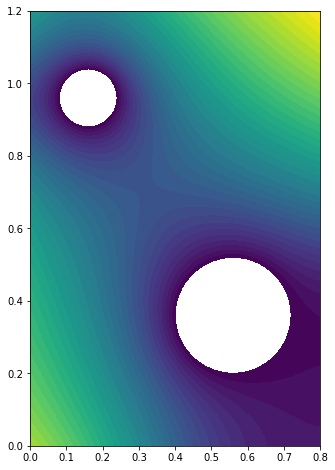

In [15]:
# Save solution in VTK format
file = dl.File("fwd_result/nonlinear_poisson_equation_newton.pvd")
file << u

# to compare with results from other methods, we save the solution as u_newton
u_newton = dl.Function(V, name = 'u_newton')
u_newton.vector().zero()
u_newton.vector().axpy(1., u.vector())

# Plot solution
plt.figure(figsize=(8,8))
dl.plot(u)
plt.show()

### Compare the solutions from fenics's `solve` method and Newton method

Error (L2 norm) =  4.2768763390750165e-07


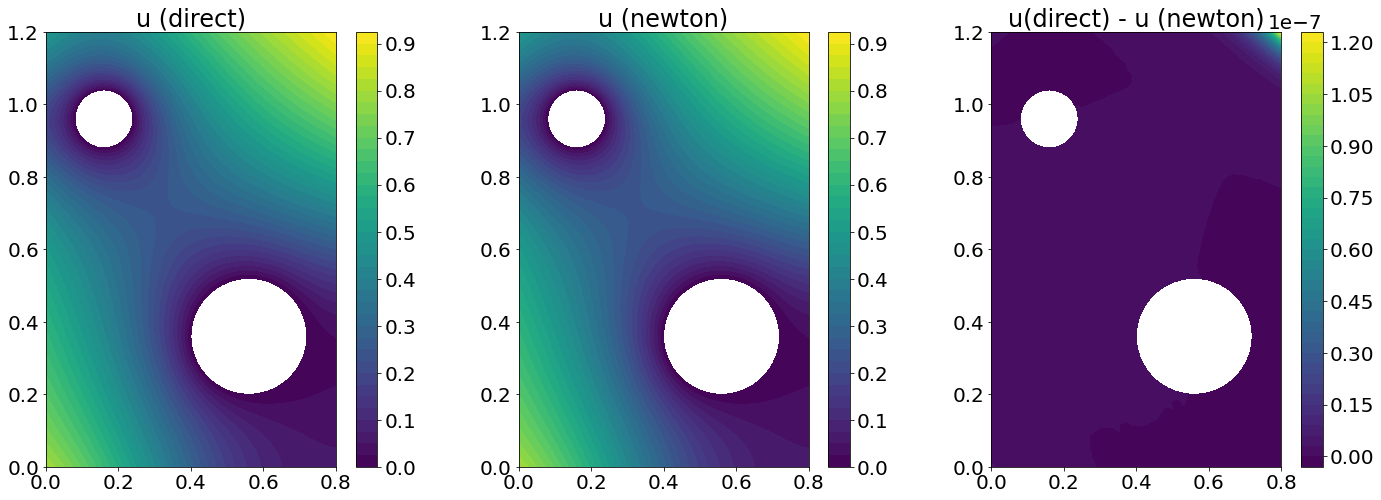

In [16]:
# compute error field
e_direct_newton = dl.Function(V, name = 'e_direct_newton')
e_direct_newton.vector().axpy(1., u_direct.vector())
e_direct_newton.vector().axpy(-1., u_newton.vector())

print('Error (L2 norm) = ', np.linalg.norm(e_direct_newton.vector()))

fig = plt.figure(figsize = (24,8))
plt.rcParams.update({'font.size': 20})

ax = plt.subplot(1,3,1)
c = dl.plot(u_direct, title = "u (direct)")
fig.colorbar(c, ax = ax)

ax = plt.subplot(1,3,2)
c = dl.plot(u_newton, title = "u (newton)")
fig.colorbar(c)


ax = plt.subplot(1,3,3)
c = dl.plot(e_direct_newton, title = "u(direct) - u (newton)")
fig.colorbar(c)

# save file
plt.savefig('results/compare_direct_newton.pdf')
plt.savefig('results/compare_direct_newton.png')

plt.show()

## Method 3: Implement Picard iteration solver

Picard iteration is another method to solve the nonlinear problems iteratively. General idea here is to approximate the nonlinear term using combination of previous iteration solution (known) and current iteration solution (unknown) so that term becomes linear in the current iteration solution, i.e., unknown variable. 

To be more precise, suppose we are iterating over solution and suppose at the $k$th iteration, solution is $u_k$ and our goal is to find the updated solution, i.e., $u_{k+1}$. Let us supppose that the updated solution $u_{k+1}$ satisfies $$R(u_{k+1}; v) = a(u_{k+1}; v) - l(v) = 0, \qquad \text{for all } v\in V.$$ Consider the definition of $a(u_{k+1};v)$:
\begin{equation}
a(u_{k+1}; v) = \int_{\Omega} \kappa (1 + u_{k+1}^2) \nabla u_{k+1} \cdot \nabla v dx .
\end{equation}
Since $u_k$ is the solution at current iteration $k$ and it is known, we can consider the following approximation of $a(u_{k+1}; v)$ by replacing $(1+u_{k+1}^2)$ with $(1+ u_k^2)$:
\begin{equation}
a(u_{k+1}; v) \approx \hat{a}_k(u_{k+1}, v) := \int_{\Omega} \kappa (1 + u_{k}^2) \nabla u_{k+1} \cdot \nabla v dx .
\end{equation}
It should be noted that $\hat{a}_k(u,v)$ is linear in both $u$ and $v$, and dependence on $u_k$ is indicated by the subscript $k$ in $\hat{a}_k$. Considering approximation $\hat{a}_k(u_{k+1}, v)$ of $a(u_{k+1}; v)$, the new problem to compute the updated solution $u_{k+1}$ is: 
\begin{equation}
\text{find } u_{k+1} \text{ such that} \qquad \hat{a}_k(u_{k+1}, v) - l(v) = 0 \qquad \text{for all } v\in V.
\end{equation}

### Implementation in Fenics

In what follows, we implement the following algorithm:
- Let $u_0$ be initial guess and $tol$ appropriately choosen tolerance
- for k = 0, 1, 2, ..., $N_{max}$
    - Let $u_k \in V$ be the solution at step $k$
    - Find $u_{k+1}\in V$ such that $\hat{a}_k(u_{k+1}, v) - l(v) = 0$ for all $v\in V$
    - Convergence check: if $||u_k - u_{k+1}||_{L^2} < tol$, Stop iteration and set $u = u_{k+1}$

In [17]:
# solution at kth iteration
uk = dl.Function(V)

# updated solution
ukk = dl.TrialFunction(V)

# test function
v = dl.TestFunction(V)

# forcing term
f = dl.Expression("x[0]*sin(x[1])", degree=2)

# diffusivity coefficient
kappa = dl.Constant(0.75)

# linearized form (see Picard iteration method explanation above)
ahat = kappa * dl.inner((1 + uk**2)*dl.grad(ukk), dl.grad(v))*dl.dx

# linear form
l = f*v*dl.dx + g*v*ds

In [18]:
# Picard iterations
Nmax = 50
tol = 1.e-6
# current solution
u = dl.Function(V, name = 'u')

# NOTE: uk is a solution at kth iteration, u is a solution at the k+1 iteration 
# i.e, u is updated solution and uk is old solution

# iteration
for k in range(1, Nmax):
    
    # assemble matrix and vector to solve Ax = b, where x is the solution
    A = dl.assemble(ahat)
    b = dl.assemble(l)
    
    # apply homogeneous Dirichlet boundary condition explicitly
    u_bc.apply(A, b)
    
    # solve (specify matrix, solution vector, and rhs vector b)
    dl.solve(A, u.vector(), b)
    
    # check for convergence
    err_l2 = np.linalg.norm(u.vector() - uk.vector())
    print('err_l2', err_l2)
    if err_l2 < tol:
        print('stopping picard iteration as the error is below tolerance')
        break

    # since we are going to the next iteration, we need to update the old solution for the next iteration
    uk.vector().zero()
    uk.vector().axpy(1., u.vector())

err_l2 45.94937999032538
err_l2 6.075267247770477
err_l2 0.9038513614586273
err_l2 0.11488876430327642
err_l2 0.012208508848010478
err_l2 0.0011199035772962657
err_l2 9.008352806334094e-05
err_l2 6.4456451920485886e-06
err_l2 4.149686620371551e-07
stopping picard iteration as the error is below tolerance


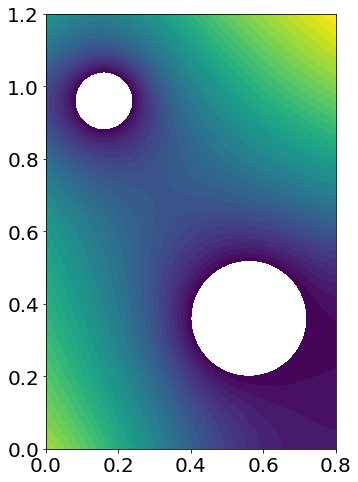

In [19]:
# Save solution in VTK format
file = dl.File("fwd_result/nonlinear_poisson_equation_icard.pvd")
file << u

# to compare with results from other methods, we save the solution as u_picard
u_picard = dl.Function(V, name = 'u_picard')
u_picard.vector().zero()
u_picard.vector().axpy(1., u.vector())

# Plot solution
plt.figure(figsize=(8,8))
dl.plot(u)
plt.show()

### Compare the solutions from fenics's solve method and Picard method

Error (L2 norm) =  4.057790852735323e-07


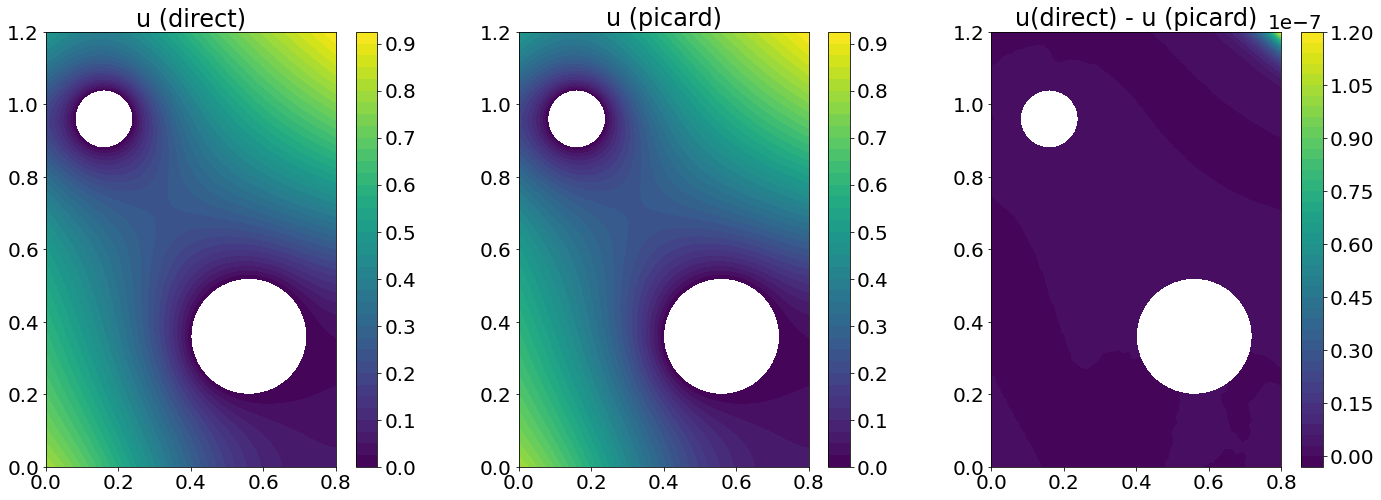

In [20]:
# compute error field
e_direct_picard = dl.Function(V, name = 'e_direct_picard')
e_direct_picard.vector().axpy(1., u_direct.vector())
e_direct_picard.vector().axpy(-1., u_picard.vector())

print('Error (L2 norm) = ', np.linalg.norm(e_direct_picard.vector()))

fig = plt.figure(figsize = (24,8))
plt.rcParams.update({'font.size': 20})

ax = plt.subplot(1,3,1)
c = dl.plot(u_direct, title = "u (direct)")
fig.colorbar(c, ax = ax)

ax = plt.subplot(1,3,2)
c = dl.plot(u_picard, title = "u (picard)")
fig.colorbar(c)


ax = plt.subplot(1,3,3)
c = dl.plot(e_direct_picard, title = "u(direct) - u (picard)")
fig.colorbar(c)

# save file
plt.savefig('results/compare_direct_picard.pdf')
plt.savefig('results/compare_direct_picard.png')

plt.show()

### Plot solutions from all three methods together

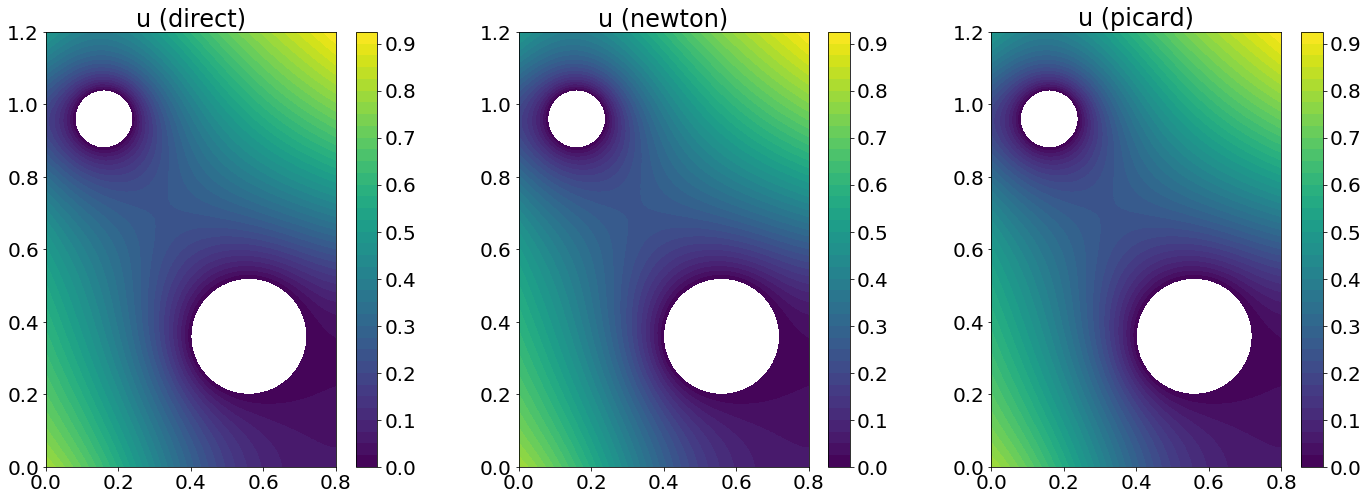

In [21]:
fig = plt.figure(figsize = (24,8))
plt.rcParams.update({'font.size': 20})

ax = plt.subplot(1,3,1)
c = dl.plot(u_direct, title = "u (direct)")
fig.colorbar(c, ax = ax)

ax = plt.subplot(1,3,2)
c = dl.plot(u_newton, title = "u (newton)")
fig.colorbar(c)

ax = plt.subplot(1,3,3)
c = dl.plot(u_picard, title = "u (picard)")
fig.colorbar(c)

# save file
plt.savefig('results/compare_direct_newton_picard.pdf')
plt.savefig('results/compare_direct_newton_picard.png')

plt.show()

# Further reading

- Fenics demo [nonlinear Poisson equation](https://fenicsproject.org/olddocs/dolfin/2019.1.0/python/demos/nonlinear-poisson/demo_nonlinear-poisson.py.html)
- [Fenics tutorial on nonlinear problems](https://home.simula.no/~hpl/homepage/fenics-tutorial/release-1.0/webm/nonlinear.html)
